In [1]:
# https://github.com/sebastianheinz/stockprediction
# https://medium.com/mlreview/a-simple-deep-learning-model-for-stock-price-prediction-using-tensorflow-30505541d877

In [2]:
# select gpu
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [3]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import time

In [4]:
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MSE
from tensorflow.keras.optimizers import Adam

In [5]:
# read stacks data
data = pd.read_csv('data_stocks.csv')
data.describe()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
count,4.126600e+04,41266.000000,41266.000000,41266.000000,41266.00000,41266.000000,41266.000000,41266.000000,41266.000000,41266.000000,...,41266.000000,41266.000000,41266.000000,41266.000000,41266.000000,41266.000000,41266.000000,41266.000000,41266.000000,41266.000000
mean,1.497749e+09,2421.537882,47.708346,150.453566,141.31793,79.446873,103.480398,102.998608,50.894352,122.981163,...,97.942211,104.740666,46.664402,43.043984,80.784595,19.300718,54.541988,71.757891,121.423515,60.183874
std,3.822211e+06,39.557135,3.259377,6.236826,6.91674,2.000283,4.424244,9.389788,4.833931,11.252010,...,5.411795,10.606694,1.508444,1.714533,1.840989,11.686532,3.526321,4.038272,5.607070,3.346887
min,1.491226e+09,2329.139900,40.830000,140.160000,128.24000,74.800000,95.870000,83.000000,44.650000,96.250000,...,83.410000,89.510000,44.090000,39.120000,76.060000,6.660000,48.820000,63.180000,110.120000,52.300000
25%,1.494432e+09,2390.860100,44.945400,144.640000,135.19500,78.030000,101.300000,94.820000,47.440000,116.950000,...,95.960000,95.010000,45.155000,41.955000,80.220000,7.045000,51.630000,69.110000,117.580000,59.620000
50%,1.497638e+09,2430.149900,48.360000,149.945000,142.26000,79.410000,102.440000,106.820000,49.509900,123.620000,...,99.250000,99.660000,46.810000,43.200000,81.150000,27.890000,53.850000,73.470000,120.650000,61.585600
75%,1.501090e+09,2448.820100,50.180000,155.065000,147.10000,80.580000,104.660000,110.490000,52.230000,132.218800,...,102.080000,117.034700,47.730000,44.370000,82.062050,30.470000,57.140000,74.750000,126.000000,62.540000
max,1.504210e+09,2490.649900,54.475000,164.510000,155.33000,90.440000,121.770000,119.270000,62.560000,142.875000,...,106.375000,123.870000,49.660000,47.210000,83.630000,32.930000,62.130000,77.120000,133.450000,63.840000


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41266 entries, 0 to 41265
Columns: 502 entries, DATE to NYSE.ZTS
dtypes: float64(501), int64(1)
memory usage: 158.0 MB


In [7]:
data.head()

,DATE,SP500,NASDAQ.AAL,NASDAQ.AAPL,NASDAQ.ADBE,NASDAQ.ADI,NASDAQ.ADP,NASDAQ.ADSK,NASDAQ.AKAM,NASDAQ.ALXN,...,NYSE.WYN,NYSE.XEC,NYSE.XEL,NYSE.XL,NYSE.XOM,NYSE.XRX,NYSE.XYL,NYSE.YUM,NYSE.ZBH,NYSE.ZTS
0,1491226200,2363.6101,42.3300,143.6800,129.6300,82.040,102.2300,85.2200,59.760,121.52,...,84.370,119.035,44.40,39.88,82.03,7.36,50.22,63.86,122.000,53.350
1,1491226260,2364.1001,42.3600,143.7000,130.3200,82.080,102.1400,85.6500,59.840,121.48,...,84.370,119.035,44.11,39.88,82.03,7.38,50.22,63.74,121.770,53.350
2,1491226320,2362.6799,42.3100,143.6901,130.2250,82.030,102.2125,85.5100,59.795,121.93,...,84.585,119.260,44.09,39.98,82.02,7.36,50.12,63.75,121.700,53.365
3,1491226380,2364.3101,42.3700,143.6400,130.0729,82.000,102.1400,85.4872,59.620,121.44,...,84.460,119.260,44.25,39.99,82.02,7.35,50.16,63.88,121.700,53.380
4,1491226440,2364.8501,42.5378,143.6600,129.8800,82.035,102.0600,85.7001,59.620,121.60,...,84.470,119.610,44.11,39.96,82.03,7.36,50.20,63.91,121.695,53.240


In [8]:
print('begin', time.strftime('%Y-%m-%d', time.localtime(data['DATE'].min())))
print('end', time.strftime('%Y-%m-%d', time.localtime(data['DATE'].max())))

begin 2017-04-03
end 2017-09-01


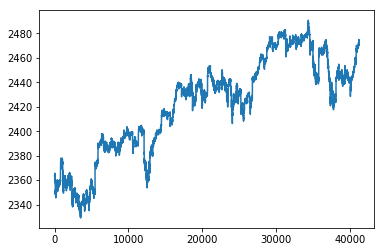

In [9]:
plt.plot(data['SP500'])

In [10]:
# train : test = 0.8 : 0.2
data.drop('DATE', axis=1, inplace=True)
data_train = data.iloc[:int(data.shape[0] * 0.8), :]
data_test = data.iloc[int(data.shape[0] * 0.8):, :]
print('training data shape:', data_train.shape)
print('test data shape', data_test.shape)

training data shape: (33012, 501)
test data shape (8254, 501)


In [11]:
# scale data into the range for -1 to 1
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(data_train)
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

In [12]:
X_train = data_train[:, 1:]
y_train = data_train[:, 0]
X_test = data_test[:, 1:]
y_test = data_test[:, 0]

In [13]:
# seq_len = 5
# X_train = np.array([data_train[i : i + seq_len, 0] for i in range(data_train.shape[0] - seq_len)]).squeeze()
# y_train = np.array([data_train[i + seq_len, 0] for i in range(data_train.shape[0] - seq_len)])
# X_test = np.array([data_test[i : i + seq_len, 0] for i in range(data_test.shape[0] - seq_len)]).squeeze()
# y_test = np.array([data_test[i + seq_len, 0] for i in range(data_test.shape[0] - seq_len)])

In [14]:
model = Sequential(layers=[
    Dense(1024, activation='relu', input_shape=X_train.shape[1:]),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='linear'),
])

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1024)              513024    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 1,202,177
Trainable params: 1,202,177
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer=Adam(lr=0.001), loss=MSE)

In [17]:
from tensorflow.keras.callbacks import LambdaCallback

In [18]:
def on_epoch_end(epoch, logs):
    y_pred = model.predict(X_test)
    plt.plot(y_test, label='test')
    plt.plot(y_pred, label='pred')
    plt.legend()
    plt.show()

Epoch 1/5
32512/33012 [============================>.] - ETA: 0s - loss: 0.0101

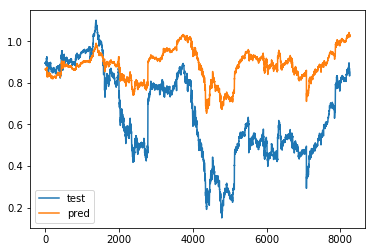

33012/33012 [==============================] - 2s 73us/step - loss: 0.0099
Epoch 2/5
32768/33012 [============================>.] - ETA: 0s - loss: 1.7015e-04

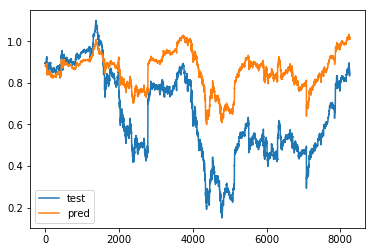

33012/33012 [==============================] - 1s 42us/step - loss: 1.6941e-04
Epoch 3/5
32000/33012 [============================>.] - ETA: 0s - loss: 2.1466e-04

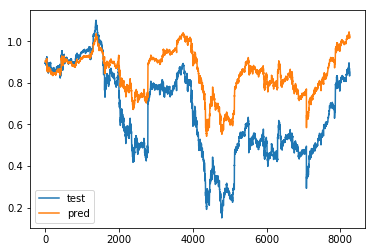

33012/33012 [==============================] - 1s 42us/step - loss: 2.1038e-04
Epoch 4/5
31488/33012 [===========================>..] - ETA: 0s - loss: 1.1966e-04

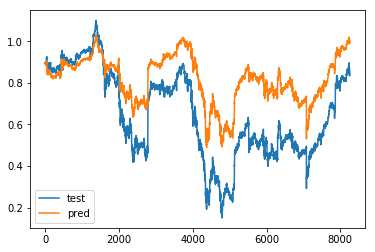

33012/33012 [==============================] - 1s 44us/step - loss: 1.1896e-04
Epoch 5/5
32000/33012 [============================>.] - ETA: 0s - loss: 2.0731e-04

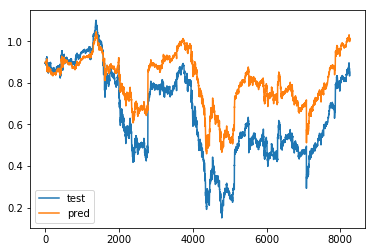

33012/33012 [==============================] - 1s 44us/step - loss: 2.0534e-04


In [19]:
model.fit(X_train, y_train,
          epochs=5,
          batch_size=256,
          shuffle=True,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)])

In [20]:
from tensorflow.keras.layers import Input, Dense, CuDNNLSTM, InputLayer
from tensorflow.keras.models import Sequential

In [21]:
seq_len = 5
X_train = np.array([data_train[i : i + seq_len, 1:] for i in range(data_train.shape[0] - seq_len)])#[:, :, np.newaxis]
y_train = np.array([data_train[i + seq_len, 0] for i in range(data_train.shape[0] - seq_len)])
X_test = np.array([data_test[i : i + seq_len, 1:] for i in range(data_test.shape[0] - seq_len)]) #[:, :, np.newaxis]
y_test = np.array([data_test[i + seq_len, 0] for i in range(data_test.shape[0] - seq_len)])

In [22]:
X_train.shape

(33007, 5, 500)

In [23]:
lstm_model = Sequential(layers=[
    InputLayer(input_shape=X_train.shape[1:]),
    CuDNNLSTM(128),
    Dense(1, activation='linear'),
])

In [24]:
lstm_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm (CuDNNLSTM)       (None, 128)               322560    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 322,689
Trainable params: 322,689
Non-trainable params: 0
_________________________________________________________________


In [25]:
lstm_model.compile(loss=MSE, optimizer=Adam())

In [26]:
def on_epoch_end(epoch, logs):
    y_pred = lstm_model.predict(X_train)
    plt.plot(y_train, label='test')
    plt.plot(y_pred, label='pred')
    plt.legend()
    plt.show()

Epoch 1/5
32512/33007 [============================>.] - ETA: 0s - loss: 0.0197

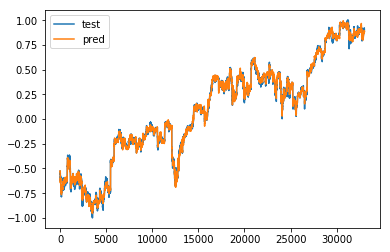

33007/33007 [==============================] - 3s 101us/step - loss: 0.0194
Epoch 2/5
32256/33007 [============================>.] - ETA: 0s - loss: 3.2466e-04

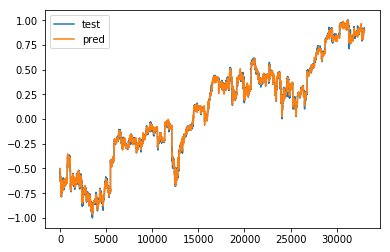

33007/33007 [==============================] - 3s 80us/step - loss: 3.2286e-04
Epoch 3/5
31744/33007 [===========================>..] - ETA: 0s - loss: 2.3210e-04

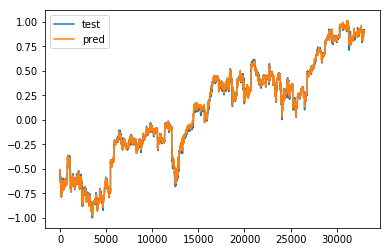

33007/33007 [==============================] - 3s 80us/step - loss: 2.3420e-04
Epoch 4/5
32512/33007 [============================>.] - ETA: 0s - loss: 2.0556e-04

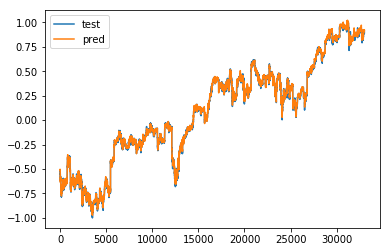

33007/33007 [==============================] - 3s 76us/step - loss: 2.0526e-04
Epoch 5/5
31488/33007 [===========================>..] - ETA: 0s - loss: 1.9163e-04

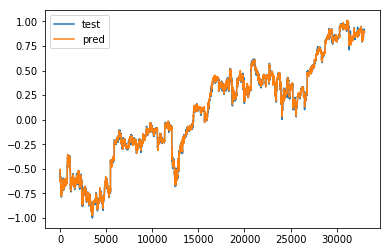

33007/33007 [==============================] - 3s 80us/step - loss: 1.9080e-04


In [27]:
lstm_model.fit(X_train, y_train,
          epochs=5,
          batch_size=256,
          shuffle=True,
          callbacks=[LambdaCallback(on_epoch_end=on_epoch_end)]
              )